# Transfer learning / fine-tunning

Transfer learning / fine-tunning utilizando o modelo [VGG16](https://arxiv.org/pdf/1409.1556.pdf), realizado com o objetivo de classificar imagens de **Maradona** e **Pelé**.

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000.

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

If you wish to use your own dataset, it should be aranged in the same fashion to `101_ObjectCategories` with all of the images organized into subfolders, one for each class. In this case, the following cell should load your custom dataset correctly by just replacing `root` with your folder. If you have an alternate structure, you just need to make sure that you load the list `data` where every element is a dict where `x` is the data (a 1-d numpy array) and `y` is the label (an integer). Use the helper function `get_image(path)` to load the image correctly into the array, and note also that the images are being resized to 224x224. This is necessary because the input to VGG16 is a 224x224 RGB image. You do not need to resize them on your hard drive, as that is being done in the code below.

If you have `101_ObjectCategories` in your data folder, the following cell should load all the data.

### Conexão com o Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -lha /content/drive/MyDrive/datasets/transfer-learning/

total 8.0K
drwx------ 2 root root 4.0K Feb  4 00:38 Maradona
drwx------ 2 root root 4.0K Feb  4 00:39 Pele


### Carrega as classes do dataset

In [4]:
root = '/content/drive/MyDrive/datasets/transfer-learning/'
include = ['Maradona', 'Pele']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c in [os.path.join(root, e) for e in include]]

print(categories)

['/content/drive/MyDrive/datasets/transfer-learning/Maradona', '/content/drive/MyDrive/datasets/transfer-learning/Pele']


Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada.

In [5]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carrega todas as imagens da pasta raiz

In [7]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

num_classes = len(categories)

Randomiza a ordem dos dados

In [8]:
random.shuffle(data)

Separa o dataset em treinamento / validação / teste (70%, 15%, 15%)

In [9]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separa os dados para os rótulos

In [10]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]


Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1

In [11]:
# normaliza os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# converte rótulos para vetores one-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(25, 2)


Resumo

In [12]:
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 166 images from 2 categories
train / validation / test split: 116, 25, 25
training data shape:  (116, 224, 224, 3)
training labels shape:  (116, 2)


Exibe algumas imagens de exemplo do nosso dataset

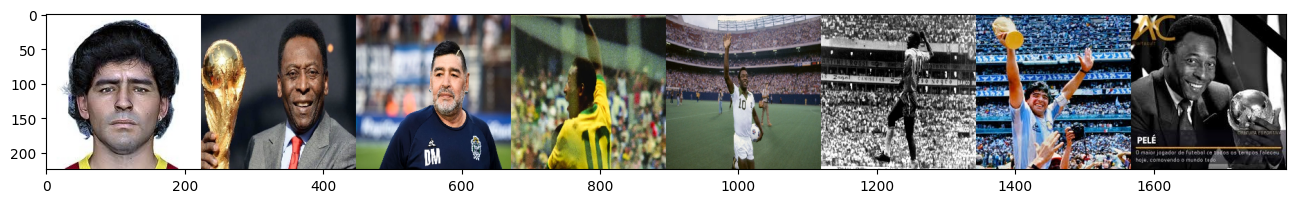

In [13]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Transfer learning com o modelo VGG16


In [14]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Para usar esta rede para nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 2 neurônios.

In [15]:
inp = vgg.input
new_classification_layer = Dense(num_classes, activation='softmax')
out = new_classification_layer(vgg.layers[-2].output)
model_new = Model(inp, out)

Congela os pesos e vieses em todas as camadas da rede, exceto a nova no final, com a expectativa de que os recursos que foram aprendidos no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens.

Ao definir o sinalizador trainable como False em cada camada (exceto nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos na única camada no final.

In [16]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Inicia o treinamento do modelo

In [17]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.5086 - loss: 0.8673 - val_accuracy: 0.4400 - val_loss: 1.5892
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4914 - loss: 1.4225 - val_accuracy: 0.4400 - val_loss: 1.0695
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4914 - loss: 0.9596 - val_accuracy: 0.5600 - val_loss: 0.7268
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step - accuracy: 0.5172 - loss: 0.7269 - val_accuracy: 0.5600 - val_loss: 0.9392
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - accuracy: 0.5086 - loss: 1.0063 - val_accuracy: 0.5600 - val_loss: 0.8893
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - accuracy: 0.5086 - loss: 0.9480 - val_accuracy: 0.5600 - val_loss: 0.7042
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5172 - loss: 0.7094 - val_accuracy: 0.4800 - val_loss: 0.7475
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step - accuracy: 0.5172 - loss: 0.6877 - val_accuracy: 0.4400 - val_loss: 0.9230
Ep

Exibe as métricas de treinamento.

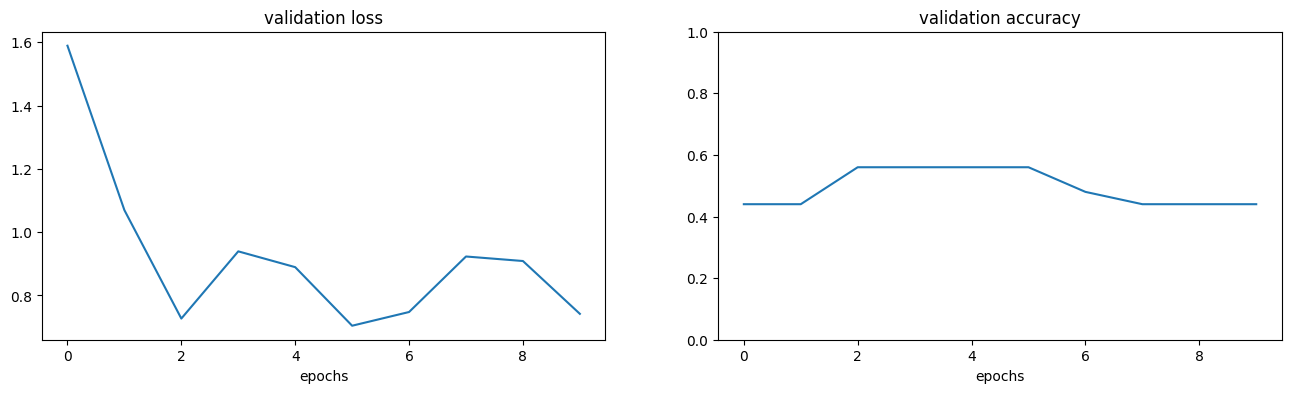

In [18]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [19]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6247497797012329
Test accuracy: 0.5600000023841858


Para prever uma nova imagem, basta executar o seguinte código para obter as probabilidades para cada classe.

In [20]:
img, x = get_image('/content/drive/MyDrive/datasets/transfer-learning/Maradona/190536018324c8ba223260898c57d89df17f91d4.jpeg')
probabilities = model_new.predict([x])


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1, 224, 224, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [21]:
predicted_class_indices = np.argmax(probabilities, axis=1)
print(probabilities)
print(predicted_class_indices)

for i in predicted_class_indices:
    print(f"Predicted class: {categories[i]}")


[[0.6515615  0.34843853]]
[0]
Predicted class: /content/drive/MyDrive/datasets/transfer-learning/Maradona
